## Imports, Matplotlib Setup, Auto-Reloading

In [1]:
from __future__ import division

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize, imshow
import cPickle as pickle

from discriminator import *
from transformer import *
from data_utils import *
from util import *
from solver import *

# some setup code
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading CIFAR-10 Data

In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()

# flag as to whether to use full or small dataset
full_data = False

# unpack CIFAR data
if full_data:
    X_train, y_train = data['X_train'], data['y_train']
else:
    X_train, y_train = data['X_train'][:5000], data['y_train'][:5000]
    
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

print 'training dataset shapes:', X_train.shape, y_train.shape
print 'validation dataset shapes:', X_val.shape, y_val.shape
print 'testing dataset shapes:', X_test.shape, y_test.shape

data = { 
    'X_train' : X_train,
    'y_train' : y_train,
    'X_val' : X_val,
    'y_val' : y_val
    }

training dataset shapes: (5000, 3, 32, 32) (5000,)
validation dataset shapes: (1000, 3, 32, 32) (1000,)
testing dataset shapes: (1000, 3, 32, 32) (1000,)


## Creating Transformer and Discriminator Objects

In [3]:
# create transformer / discriminator objects
transformer = Transformer()

# if we have a trained model saved
if os.path.isfile('../models/discrim.p'):
    # load it from the pickle file
    discriminator = pickle.load(open('../models/discrim.p', 'rb'))
else:
    # create a new discriminator object
    discriminator = Discriminator(reg=1.5e-3, weight_scale=3.25e-2, num_filters=32, hidden_dim=750)
    
    # create a solver object to do the training
    solver = Solver(discriminator, data, num_epochs=3, batch_size=150, update_rule='adam', optim_config={'learning_rate': 3.2e-3}, verbose=True)
    
    # train the discriminator on the CIFAR-10 data as in assignment 2
    solver.train()
    
    # persist the model using pickle
    pickle.dump(discriminator, open('../models/discrim.p', 'wb'))

## Training Adversarial Pair

In [11]:
# store training dataset range, size
train_range = range(len(X_train))

# batch size
batch_size = 100

# number of epochs, iterations per epoch, iterations
n_epochs = 3
iters_per_epoch = int( max(len(X_train) / batch_size, 1) )
n_iters = n_epochs * iters_per_epoch

# hyperparameters
update_rule = getattr(optim, 'adam')
discriminator_optim_config = {}
transformer_optim_config = {}

# making copies of optim_config for each parameter
discriminator_optim_configs = {}
for p in discriminator.params:
    d = {k: v for k, v in discriminator_optim_config.iteritems()}
    discriminator_optim_configs[p] = d
    
# making copies of optim_config for each parameter
transformer_optim_configs = {}
for p in discriminator.params:
    d = {k: v for k, v in transformer_optim_config.iteritems()}
    transformer_optim_configs[p] = d

print_every = 10

for t in range(n_iters):
    if t % print_every == 0:
        print 'Iteration %d / %d' % (t + 1, n_iters)
    
    ########################
    # UPDATE DISCRIMINATOR #
    ########################
    
    # choose a minibatch of images from the training set and their corresponding label
    idxs = np.random.choice(train_range, batch_size)
    X, y = X_train[idxs], y_train[idxs]
    
    # update the discriminator by training it on the selected minibatch
    loss, grads, _ = discriminator.loss(X, y)
    
    if t % print_every == 0:
        print 'Discriminator training loss:', loss
    
    # perform a parameter update
    for p, w in discriminator.params.iteritems():
        # get associated gradient
        dw = grads[p]
        # get associated hyperparameters
        config = discriminator_optim_configs[p]
        # get next weights and next optimization configuration
        next_w, next_config = update_rule(w, dw)
        # update the parameter's weights
        discriminator.params[p] = next_w
        # update optimization configuration
        discriminator_optim_configs[p] = next_config
    
    ######################
    # UPDATE TRANSFORMER #
    ######################
    
    # choose a minibatch of images from the training set and their corresponding label
    idxs = np.random.choice(train_range, batch_size)
    X, y = X_train[idxs], y_train[idxs]
            
    # get the transform of the training data point
    transform = transformer.forward(X)
    transform = transform.reshape(X.shape)
        
    # pass the transform into the discriminator network
    loss, grads, scores = discriminator.loss(transform, np.array([10]*batch_size))
    
    if t % print_every == 0:
        print 'Discriminator loss on fake data:', loss
    
    # perform a parameter update
    for p, w in discriminator.params.iteritems():
        # get associated gradient
        dw = grads[p]
        # get associated hyperparameters
        config = discriminator_optim_configs[p]
        # get next weights and next optimization configuration
        next_w, next_config = update_rule(w, dw)
        # update the parameter's weights
        discriminator.params[p] = next_w
        # update optimization configuration
        discriminator_optim_configs[p] = next_config
        
    # use the scores to calculate the loss and gradients for the transformer network
    transformer_loss, transformer_dout = inverse_softmax_loss(scores, y)
    dtransform, transformer_loss = discriminator.transformer_backward(transformer_loss, transformer_dout) 
        
    # backprop into transformer
    input_reshape = (transform.shape[0], np.prod(transform.shape[1:]))
    loss, grads = transformer.backward(transform.reshape(input_reshape), transformer_loss, dtransform.reshape(input_reshape))
    
    if t % print_every == 0:
        print 'Transformer loss (?)', loss    
        
    # perform a parameter update
    for p, w in transformer.params.iteritems():
        # get associated gradient
        dw = grads[p]
        # get associated hyperparameters
        config = transformer_optim_configs[p]
        # get next weights and next optimization configuration
        next_w, next_config = update_rule(w, dw)
        # update the parameter's weights
        transformer.params[p] = next_w
        # update optimization configuration
        transformer_optim_configs[p] = next_config

Iteration 1 / 150
Discriminator training loss: 8.83310528232
Discriminator loss on fake data: 16.2028312756
Transformer loss (?) 8.17204371691
Iteration 11 / 150
Discriminator training loss: 8.91130705166
Discriminator loss on fake data: 14.9036833071
Transformer loss (?) 8.50589763381
Iteration 21 / 150
Discriminator training loss: 9.47309145943
Discriminator loss on fake data: 10.4045805159
Transformer loss (?) 8.49634251223
Iteration 31 / 150
Discriminator training loss: 9.77916066519
Discriminator loss on fake data: 9.0007112488
Transformer loss (?) 8.51963852972
Iteration 41 / 150
Discriminator training loss: 9.65436666958
Discriminator loss on fake data: 8.75091830405
Transformer loss (?) 8.59190993342
Iteration 51 / 150
Discriminator training loss: 9.98008340232
Discriminator loss on fake data: 8.77325395475
Transformer loss (?) 8.6865053421
Iteration 61 / 150
Discriminator training loss: 10.2743626865
Discriminator loss on fake data: 8.79453724857
Transformer loss (?) 8.7785141

## Benchmark Accuracy of Discriminatively Trained Model

In [14]:
# load our pretrained model
old_discriminator = pickle.load(open('../models/discrim.p', 'rb'))

print '...finished loading old model'

# check accuracy of pretrained model on the validation set

# get the number of batches
num_batches = int(len(X_val) / batch_size)
if len(X_val) % batch_size != 0:
  num_batches += 1

# get predictions
y_pred = []
for i in xrange(num_batches):
    
    # get beginning / end of batch
    start = i * batch_size
    end = (i + 1) * batch_size
    
    # get scores from the model
    scores = old_discriminator.loss(X[start:end])
    
    # store the predicted labels from the scores
    y_pred.append(np.argmax(scores, axis=1))

# calculate the accuracy of the pretrained model on the validation set
y_pred = np.hstack(y_pred)
print 'pretrained accuracy:', np.mean(y_pred == y)

# check accuracy of adversarially trained model on the validation set

# get predictions
y_pred = []
for i in xrange(num_batches):
    
    # get beginning / end of batch
    start = i * batch_size
    end = (i + 1) * batch_size
    
    # get scores from the model
    scores = discriminator.loss(X[start:end])
    
    # store the predicted labels from the scores
    y_pred.append(np.argmax(scores, axis=1))

# calculate the accuracy of the pretrained model on the validation set
y_pred = np.hstack(y_pred)
print 'adversarially trained accuracy:', np.mean(y_pred == y)

...finished loading old model


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


pretrained accuracy: 0.79
adversarially trained accuracy: 0.44


## Visualizing Learned Transformations

(3, 32, 32)


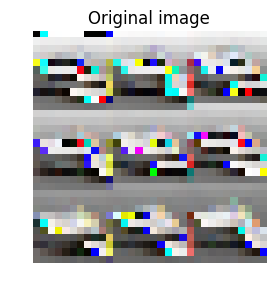

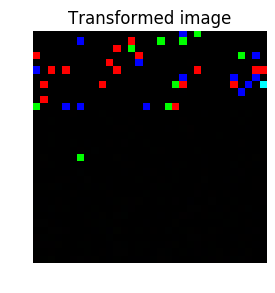

(3, 32, 32)


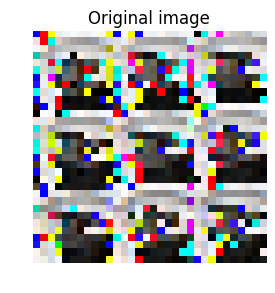

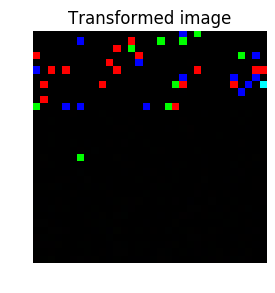

(3, 32, 32)


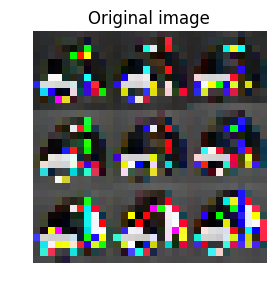

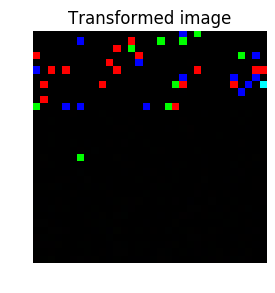

(3, 32, 32)


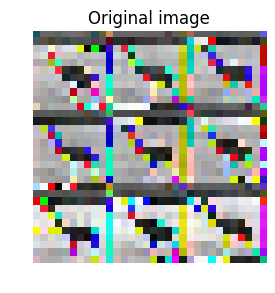

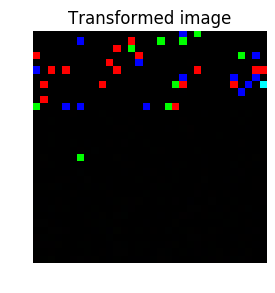

(3, 32, 32)


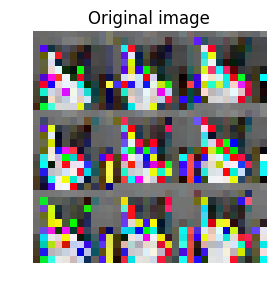

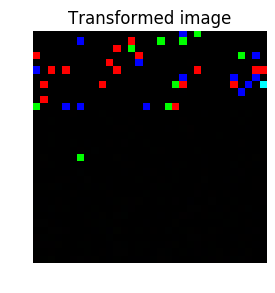

In [40]:
# number of image transformation to visualize
k = 5

# randomly sample k images from the training dataset
to_vis_idxs = np.random.choice(train_range, k)
to_vis = X_train[to_vis_idxs]

# show all images and their transformations
for img in to_vis:
    print img.shape
    
    # show the original
    plt.imshow(img.reshape((32, 32, 3)).astype('uint32'))
    plt.gcf().set_size_inches(3, 3)
    plt.title('Original image')
    plt.axis('off')
    plt.show()
    
    # show the transformation
    plt.imshow(transformer.forward(img.reshape((1, 3, 32, 32))).reshape((32, 32, 3)).astype('uint32'))
    plt.gcf().set_size_inches(3, 3)
    plt.title('Transformed image')
    plt.axis('off')
    plt.show()